In [ ]:
!nvidia-smi

Wed May 11 05:23:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import modules

In [ ]:
import torch

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100
from torch.cuda import is_available
from torchvision import transforms
from datetime import datetime

%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'
device

'cuda'

# Download dataset and calculate means and stds

In [ ]:
all_data=CIFAR100(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Mean: 0.50707513 0.48654887 0.44091785
Std: 0.20079845 0.19834627 0.20219834


# Implement CustomSubset

To use different augmentations to train subset and validation subset.

In [ ]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
transform={
    'train':transforms.Compose([
                                transforms.RandomCrop((32, 32), padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR100(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


# Define blocks

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)

        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class InceptionStem(nn.Module):
    def __init__(self, input_channels):
        super(InceptionStem, self).__init__()
        self.conv1 = nn.Sequential(
            BasicConv2d(input_channels, 32, kernel_size=3),
            BasicConv2d(32, 32, kernel_size=3, padding=1),
            BasicConv2d(32, 64, kernel_size=3, padding=1)
        )

        self.branch3x3_conv = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3_pool = nn.MaxPool2d(3, stride=1, padding=1)

        self.branch7x7a = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1),
            BasicConv2d(64, 64, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(64, 64, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(64, 96, kernel_size=3, padding=1)
        )

        self.branch7x7b = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1)
        )

        self.branchpoola = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branchpoolb = BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        x = self.conv1(x)

        x = [
            self.branch3x3_conv(x),
            self.branch3x3_pool(x)
        ]
        x = torch.cat(x, 1)

        x = [
            self.branch7x7a(x),
            self.branch7x7b(x)
        ]
        x = torch.cat(x, 1)

        x = [
            self.branchpoola(x),
            self.branchpoolb(x)
        ]

        x = torch.cat(x, 1)

        return x


class InceptionA(nn.Module):
    def __init__(self, in_channels=384, pool_features=96):
        super(InceptionA, self).__init__()

        self.branch3x3stack = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                            BasicConv2d(64, 96, kernel_size=3, padding=1),
                                            BasicConv2d(96, 96, kernel_size=3, padding=1))

        self.branch3x3 = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                       BasicConv2d(64, 96, kernel_size=3, padding=1))

        self.branch1x1 = BasicConv2d(in_channels, 96, kernel_size=1)

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 96, kernel_size=1))

    def forward(self, x):
        x = [
            self.branch3x3stack(x),
            self.branch3x3(x),
            self.branch1x1(x),
            self.branchpool(x)
        ]

        return torch.cat(x, dim=1)

# k=192, l=224, m=256, n=384
class ReductionA(nn.Module):
    def __init__(self, in_channels=384):

        super().__init__()
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 224, kernel_size=3, padding=1),
            BasicConv2d(224, 256, kernel_size=3, stride=2)
        )

        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        x = [
            self.branch3x3stack(x),
            self.branch3x3(x),
            self.branchpool(x)
        ]

        return torch.cat(x, 1)


class InceptionB(nn.Module):
    def __init__(self, in_channels=1024):
        super().__init__()

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 224, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(224, 224, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(224, 256, kernel_size=(7, 1), padding=(3, 0))
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 224, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(224, 256, kernel_size=(7, 1), padding=(3, 0))
        )

        self.branch1x1 = BasicConv2d(in_channels, 384, kernel_size=1)

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            BasicConv2d(in_channels, 128, kernel_size=1)
        )

    def forward(self, x):
        x = [
            self.branch1x1(x),
            self.branch7x7(x),
            self.branch7x7stack(x),
            self.branchpool(x)
        ]

        return torch.cat(x, 1)


class ReductionB(nn.Module):
    def __init__(self, in_channels=1024):

        super().__init__()
        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 256, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(256, 320, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2, padding=1)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=3, stride=2, padding=1)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):

        x = [
            self.branch3x3(x),
            self.branch7x7(x),
            self.branchpool(x)
        ]

        return torch.cat(x, 1)

class InceptionC(nn.Module):
    def __init__(self, in_channels=1536):
        super().__init__()

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 384, kernel_size=1),
            BasicConv2d(384, 448, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(448, 512, kernel_size=(3, 1), padding=(1, 0)),
        )
        self.branch3x3stacka = BasicConv2d(512, 256, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stackb = BasicConv2d(512, 256, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3a = BasicConv2d(384, 256, kernel_size=(3, 1), padding=(1, 0))
        self.branch3x3b = BasicConv2d(384, 256, kernel_size=(1, 3), padding=(0, 1))

        self.branch1x1 = BasicConv2d(in_channels, 256, kernel_size=1)

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 256, kernel_size=1)
        )

    def forward(self, x):
        branch3x3stack_output = self.branch3x3stack(x)
        branch3x3stack_output = [
            self.branch3x3stacka(branch3x3stack_output),
            self.branch3x3stackb(branch3x3stack_output)
        ]
        branch3x3stack_output = torch.cat(branch3x3stack_output, 1)

        branch3x3_output = self.branch3x3(x)
        branch3x3_output = [
            self.branch3x3a(branch3x3_output),
            self.branch3x3b(branch3x3_output)
        ]
        branch3x3_output = torch.cat(branch3x3_output, 1)

        branch1x1_output = self.branch1x1(x)

        branchpool = self.branchpool(x)

        output = [
            branch1x1_output,
            branch3x3_output,
            branch3x3stack_output,
            branchpool
        ]

        return torch.cat(output, 1)

# Define Inception V4

In [ ]:
class InceptionV4(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.stem = InceptionStem(3)
        self.inception_a = nn.Sequential(InceptionA(384),
                                         InceptionA(384),
                                         InceptionA(384),
                                         InceptionA(384))
        self.reduction_a = ReductionA(384)
        self.inception_b = nn.Sequential(InceptionB(1024),
                                         InceptionB(1024),
                                         InceptionB(1024),
                                         InceptionB(1024),
                                         InceptionB(1024),
                                         InceptionB(1024),
                                         InceptionB(1024))
        self.reduction_b = ReductionB(1024)
        self.inception_c = nn.Sequential(InceptionC(1536),
                                         InceptionC(1536),
                                         InceptionC(1536))
        self.avgpool = nn.AvgPool2d(7)

        self.dropout = nn.Dropout2d(1 - 0.8)
        self.linear = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(-1, 1536)
        x = self.linear(x)

        return x

# Prepare training step

In [ ]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
model = InceptionV4(num_classes=100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

model = model.to(device)
criterion = criterion.to(device)

# Train and validation

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, print_every=1, early_stop=None, model_path='inception_v4.pth'):
    train_logs = {'Loss':[], 'Accuracy':[]}
    valid_logs = {'Loss':[], 'Accuracy':[]}
    try:
        patience = 0
        best_acc = -np.inf
        start_time = datetime.now()
        for epoch in range(num_epochs):
            train_loss = 0
            valid_loss = 0
            train_acc = 0
            valid_acc = 0
            # training step
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred,target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == target).item()
            train_loss /= len(train_data)
            train_acc /= len(train_data)
            train_logs['Loss'].append(train_loss)
            train_logs['Accuracy'].append(train_acc)
            if (epoch + 1) % print_every == 0:
                print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, train_loss, train_acc * 100, datetime.now() - start_time))
            # validation step
            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)
                    pred = model(data)
                    loss = criterion(pred,target)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == target).item()
                valid_loss /= len(valid_data)
                valid_acc /= len(valid_data)
                valid_logs['Loss'].append(valid_loss)
                valid_logs['Accuracy'].append(valid_acc)
                if (epoch+1) % print_every == 0:
                    print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, valid_loss, valid_acc * 100, datetime.now() - start_time))
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    torch.save(model.state_dict(), model_path)
                    if early_stop is not None:
                        patience = 0
                elif early_stop is not None:
                    patience += 1
                    if patience >= early_stop:
                        print('Training finished by early stopping')
                        return train_logs, valid_logs
        return train_logs, valid_logs
    except KeyboardInterrupt:
        return train_logs, valid_logs

In [ ]:
train_logs, valid_logs = train(model=model,
                               criterion=criterion,
                               optimizer=optimizer,
                               train_loader=train_loader,
                               valid_loader=valid_loader,
                               num_epochs=50,
                               print_every=1,
                               early_stop=None,
                               model_path='inception_v4.pth')

Training   Epoch 0 - Loss : 4.47618117 Accuracy : 2.2000% Time elapsed: 0:07:37.432984
Validation Epoch 0 - Loss : 4.31613079 Accuracy : 3.0500% Time elapsed: 0:08:11.877256
Training   Epoch 1 - Loss : 4.13824677 Accuracy : 4.5075% Time elapsed: 0:15:48.658219
Validation Epoch 1 - Loss : 4.21224413 Accuracy : 4.2900% Time elapsed: 0:16:23.140027
Training   Epoch 2 - Loss : 3.98971228 Accuracy : 6.7500% Time elapsed: 0:23:59.655097
Validation Epoch 2 - Loss : 4.14600615 Accuracy : 5.6600% Time elapsed: 0:24:34.084333
Training   Epoch 3 - Loss : 3.90576447 Accuracy : 8.0525% Time elapsed: 0:32:10.425121
Validation Epoch 3 - Loss : 4.38987147 Accuracy : 6.4200% Time elapsed: 0:32:44.849571
Training   Epoch 4 - Loss : 3.84929982 Accuracy : 8.8525% Time elapsed: 0:40:21.496533
Validation Epoch 4 - Loss : 4.25799954 Accuracy : 6.5300% Time elapsed: 0:40:55.931056
Training   Epoch 5 - Loss : 3.82709619 Accuracy : 9.3275% Time elapsed: 0:48:34.273280
Validation Epoch 5 - Loss : 4.34098010 Accu

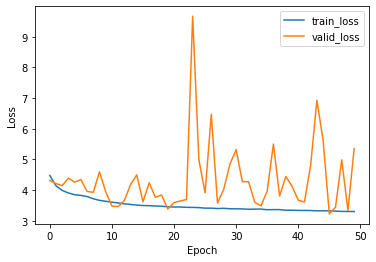

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))], train_logs['Loss'], label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))], valid_logs['Loss'], label='valid_loss')
plt.legend()
plt.show()

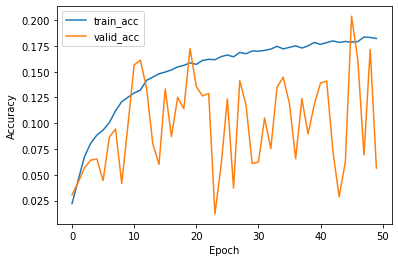

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))], train_logs['Accuracy'], label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))], valid_logs['Accuracy'], label='valid_acc')
plt.legend()
plt.show()

# Test

In [ ]:
model.load_state_dict(torch.load('inception_v4.pth'))
model = model.to(device)

In [ ]:
def test(model,criterion,test_loader):
    test_loss = 0
    test_acc = 0
    result_table = pd.DataFrame(columns=['Prediction', 'Target'])
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device) ,target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_acc += torch.sum(pred.argmax(1) == target).item()
            for p, t in zip(pred.argmax(1), target):
                result_table = result_table.append({'Prediction':p.item(), 'Target':t.item()}, ignore_index=True)
        test_loss /= len(test_data)
        test_acc /= len(test_data)
    return test_loss, test_acc, result_table

In [ ]:
test_loss, test_acc, result_table = test(model=model,
                                         criterion=criterion,
                                         test_loader=test_loader)

In [ ]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss, test_acc * 100))

Test Loss : 3.21920660 Test Accuracy : 20.0000%


In [ ]:
result_table

,Prediction,Target
0,8,49
1,80,33
2,30,72
3,66,51
4,71,71
...,...,...
9995,1,83
9996,63,14
9997,33,51
9998,42,42
